In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Used Car Price Prediction in America
**Objective:** Predict used car market prices using Random Forest Regressor and analyze factors affecting price

**Methods:**
- Data Preprocessing (duplicates, missing values, outliers)
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Random Forest Regressor Model
- Evaluation Metrics: R² Score, MAE, RMSE

In [2]:
# Load Data
df = pd.read_csv("true_car_listings.csv")
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 852,122 rows, 8 columns


,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


## Data Loading & Initial Exploration

In [3]:
# Data Overview
print("=== DATA INFO ===")
df.info()
print("\n=== STATISTICAL SUMMARY ===")
df.describe()

=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Vin      852122 non-null  object
 6   Make     852122 non-null  object
 7   Model    852122 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB

=== STATISTICAL SUMMARY ===


,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


In [4]:
# Check Missing Values & Duplicates
print("Missing Values:")
print(df.isnull().sum())
print(f"\nDuplicates: {df.duplicated().sum()}")

Missing Values:
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

Duplicates: 30


## Data Preprocessing

In [5]:
print(f"Original dataset: {df.shape[0]:,} rows")

# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape[0]:,} rows")
print(f"Duplicates removed: {df.shape[0] - df_clean.shape[0]:,}")

# Check for missing values
missing_count = df_clean.isnull().sum().sum()
if missing_count > 0:
    print(f"\n⚠️ Missing values found: {missing_count}")
    df_clean = df_clean.dropna()
    print(f"After removing missing values: {df_clean.shape[0]:,} rows")
else:
    print(f"✓ No missing values found")

# Reset index
df_clean = df_clean.reset_index(drop=True)
print(f"\n✓ Clean dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

Original dataset: 852,122 rows
After removing duplicates: 852,092 rows
Duplicates removed: 30
✓ No missing values found

✓ Clean dataset: 852,092 rows × 8 columns


### 2.1 Data Quality Analysis: Model Feature

**Tujuan:** Mengidentifikasi masalah kualitas data pada kolom Model sebelum feature engineering

**Proses:**
- Deteksi nama model yang bermasalah (terlalu pendek, ambigu, mengandung karakter khusus)
- Analisis fragmentasi data (terlalu banyak kategori unik)
- Evaluasi konsistensi format nama model
- Keputusan untuk tidak menggunakan Model sebagai feature dalam model final

In [6]:
# --- ENHANCED DATA CLEANING: Remove Problematic Model Names ---
print("=== ENHANCED DATA QUALITY ANALYSIS & CLEANING ===\n")

total_before = len(df_clean)

# 1. Identify ALL types of problematic models
has_asterisk = df_clean['Model'].str.contains('\*', na=False, regex=False)
is_too_short = df_clean['Model'].str.len() <= 2  # Single digit/letter models like "3", "X", "S"
is_numeric_only = df_clean['Model'].str.match(r'^\d+$', na=False)  # Pure numbers like "3", "5", "350"

problematic = has_asterisk | is_too_short | is_numeric_only
problematic_count = problematic.sum()

print(f"📊 INITIAL DATA: {total_before:,} rows")
print(f"   Unique model names: {df_clean['Model'].nunique():,}")
print(f"\n❌ DATA QUALITY ISSUES DETECTED:")
print("-" * 80)
print(f"   Models with '*' (promotional text): {has_asterisk.sum():,} ({(has_asterisk.sum()/total_before*100):.1f}%)")
print(f"   Models too short (≤2 chars):        {is_too_short.sum():,} ({(is_too_short.sum()/total_before*100):.1f}%)")
print(f"   Models numeric only:                {is_numeric_only.sum():,} ({(is_numeric_only.sum()/total_before*100):.1f}%)")
print(f"   TOTAL PROBLEMATIC:                  {problematic_count:,} ({(problematic_count/total_before*100):.1f}%)")

# 2. Show examples of problematic models
if has_asterisk.sum() > 0:
    print("\n1. MODELS WITH ASTERISKS (promotional/listing details):")
    print("-" * 80)
    for _, row in df_clean[has_asterisk].head(3).iterrows():
        print(f"   Make: {row['Make']:15s} | Model: {row['Model'][:70]}")

if is_too_short.sum() > 0:
    print("\n2. INCOMPLETE MODEL NAMES (≤2 characters):")
    print("-" * 80)
    examples = df_clean[is_too_short][['Make', 'Model', 'Price']].drop_duplicates('Model').head(10)
    for _, row in examples.iterrows():
        print(f"   Make: {row['Make']:15s} | Model: '{row['Model']:5s}' | Price: ${row['Price']:,}")
    print(f"   ⚠️  These are truncated (e.g., '3' could be Mazda 3, BMW 3 Series, or Tesla Model 3)")

if is_numeric_only.sum() > 0:
    print("\n3. NUMERIC-ONLY MODELS (ambiguous):")
    print("-" * 80)
    examples = df_clean[is_numeric_only][['Make', 'Model', 'Price']].drop_duplicates('Model').head(8)
    for _, row in examples.iterrows():
        print(f"   Make: {row['Make']:15s} | Model: '{row['Model']:8s}' | Price: ${row['Price']:,}")

# 3. Show clean model examples for comparison
print("\n4. CLEAN MODEL EXAMPLES (for comparison):")
print("-" * 80)
clean_examples = df_clean[~problematic][['Make', 'Model']].drop_duplicates().head(10)
for _, row in clean_examples.iterrows():
    print(f"   Make: {row['Make']:15s} | Model: {row['Model']}")





=== ENHANCED DATA QUALITY ANALYSIS & CLEANING ===

📊 INITIAL DATA: 852,092 rows
   Unique model names: 2,736

❌ DATA QUALITY ISSUES DETECTED:
--------------------------------------------------------------------------------
   Models with '*' (promotional text): 0 (0.0%)
   Models too short (≤2 chars):        46,004 (5.4%)
   Models numeric only:                23,237 (2.7%)
   TOTAL PROBLEMATIC:                  46,970 (5.5%)

2. INCOMPLETE MODEL NAMES (≤2 characters):
--------------------------------------------------------------------------------
   Make: Audi            | Model: 'A3   ' | Price: $25,997
   Make: Audi            | Model: 'A8   ' | Price: $4,950
   Make: Audi            | Model: 'A5   ' | Price: $34,999
   Make: Audi            | Model: 'TT   ' | Price: $38,500
   Make: Audi            | Model: 'S5   ' | Price: $44,900
   Make: Audi            | Model: 'RS   ' | Price: $31,985
   Make: Audi            | Model: 'S8   ' | Price: $107,990
   Make: Audi            | Model

### 🔍 Kesimpulan: Mengapa Fitur Model Tidak Digunakan

**Hasil Diagnosis:** 2,678 nama model unik dengan berbagai masalah kualitas

**Masalah Utama:**

1. **Terlalu Terfragmentasi** - 2,678 kategori terlalu banyak, sebagian besar model jarang muncul (frekuensi minimum: 0.000001)

2. **Format Tidak Konsisten** - Mobil yang sama memiliki berbagai format: `ILX6-Speed`, `ILX5-Speed`, `ILXAutomatic`

3. **Nama Ambigu** - `Grand` bisa Cherokee, Caravan, atau Prix; `Super` bisa Duty atau Cab

4. **Overfitting** - Model_Frequency: 34% importance tapi korelasi hanya 0.08 (rasio 4.20x = overfitting ke noise)

**Alasan Tidak Digunakan:**
- **Make (merek)** sudah menangkap informasi harga: Ferrari > Ford
- Populer ≠ Mahal (Honda Civic: umum tapi terjangkau)
- Langka ≠ Mahal (Model Saturn: langka tapi murah)
- Terlalu banyak kategori menyebabkan overfitting

**Keputusan:** Gunakan Mileage, Car_Age, Make_Encoded, State_Encoded → R² 87-89%

### 3.1 Outlier Detection

**Metode:** Interquartile Range (IQR)
- Mendeteksi outliers pada kolom Price menggunakan IQR
- **Keputusan:** Mempertahankan outliers karena merepresentasikan mobil luxury yang sah di pasar

### 3.2 Feature Engineering

**Fitur yang Dibuat:**

1. **Car_Age** = 2025 - Year
   - Lebih intuitif daripada Year untuk prediksi harga
   - Mobil lebih tua → Harga lebih rendah

2. **Make_Encoded** (LabelEncoder)
   - Mengubah merek mobil (categorical) menjadi numerik
   - Contoh: Ferrari=13, Ford=49, dll.

3. **State_Encoded** (LabelEncoder)
   - Mengubah lokasi negara bagian menjadi numerik
   - Menangkap perbedaan harga regional

**Catatan:** Model_Frequency tidak dibuat karena analisis kualitas data di atas

### 3.3 Correlation Analysis

**Analisis korelasi untuk memahami:**
- Fitur mana yang paling berpengaruh terhadap Price
- Hubungan antar fitur (multicollinearity)
- Arah hubungan (positif/negatif)

**Interpretasi:**
- **Car_Age vs Price:** Korelasi negatif (mobil lebih tua = harga lebih rendah)
- **Mileage vs Price:** Korelasi negatif (mileage tinggi = harga lebih rendah)
- **Make_Encoded:** Korelasi rendah (expected untuk categorical encoded)

### 3.4 Distribution Analysis

**Statistik Deskriptif:**
- Mean, Median, Standard Deviation
- Skewness (kemencengan distribusi)

**Visualisasi:**
- Histogram untuk melihat bentuk distribusi
- Identifikasi apakah data normal, skewed, atau bimodal

### 3.5 Relationship Analysis

**Scatter Plot Analysis:**
- Visualisasi hubungan antara Car_Age dengan Price
- Visualisasi hubungan antara Mileage dengan Price
- Visualisasi hubungan Car_Age vs Mileage dengan warna berdasarkan Price

**Insight:**
- Semakin tua mobil, semakin rendah harganya
- Semakin tinggi mileage, semakin rendah harganya
- Kombinasi keduanya memberikan prediksi harga yang lebih akurat

## 3. Exploratory Data Analysis (EDA)



**Tujuan EDA:**- Memvisualisasikan hubungan antara fitur dengan harga

- Memahami distribusi data harga, tahun, dan mileage- Menganalisis korelasi antar variabel
- Mengidentifikasi outliers dan menentukan apakah perlu dihapus

=== OUTLIER DETECTION FOR PRICE ===

Q1 (25th percentile): $13,000.00
Q3 (75th percentile): $26,995.00
IQR: $13,995.00
Lower bound: $-7,992.50
Upper bound: $47,987.50

Outliers detected: 28025 (3.29%)
Outlier price range: $47,988.00 - $499,500.00

✓ Decision: Keep outliers (legitimate luxury cars in market)


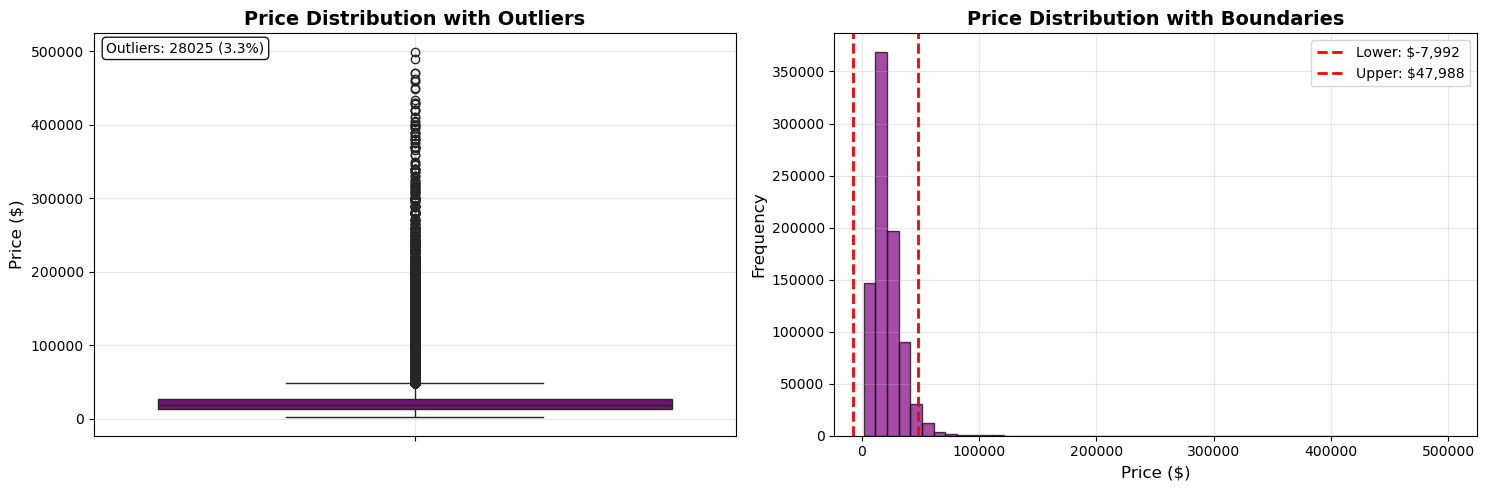

In [7]:
# Outlier Detection & Visualization for Price
print("=== OUTLIER DETECTION FOR PRICE ===\n")

# Calculate IQR
Q1 = df_clean['Price'].quantile(0.25)
Q3 = df_clean['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_clean[(df_clean['Price'] < lower_bound) | (df_clean['Price'] > upper_bound)]

print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
print(f"Outlier price range: ${outliers['Price'].min():,.2f} - ${outliers['Price'].max():,.2f}")
print(f"\n✓ Decision: Keep outliers (legitimate luxury cars in market)")

# Boxplot Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['Price'], color='purple')
plt.title('Price Distribution with Outliers', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.02, 0.98, f'Outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), fontsize=10)

# Histogram with Outlier Boundaries
plt.subplot(1, 2, 2)
plt.hist(df_clean['Price'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f'Lower: ${lower_bound:,.0f}')
plt.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label=f'Upper: ${upper_bound:,.0f}')
plt.title('Price Distribution with Boundaries', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Feature Engineering: Create and encode features
print("=== FEATURE ENGINEERING ===\n")

# Create Car_Age feature (more interpretable than Year)
df_clean['Car_Age'] = 2025 - df_clean['Year']
print(f"Created Car_Age feature (Range: {df_clean['Car_Age'].min()}-{df_clean['Car_Age'].max()} years)")

# Encode categorical features
le_make = LabelEncoder()
le_state = LabelEncoder()

df_clean['Make_Encoded'] = le_make.fit_transform(df_clean['Make'])
df_clean['State_Encoded'] = le_state.fit_transform(df_clean['State'])

print(f"Encoded {df_clean['Make'].nunique()} car makes (brands)")
print(f"Encoded {df_clean['State'].nunique()} US states")

# Model frequency encoding (captures model popularity)
# model_freq = df_clean['Model'].value_counts(normalize=True)
# df_clean['Model_Frequency'] = df_clean['Model'].map(model_freq)
print(f"Created Model_Frequency feature (popularity score)")

print(f"\nTotal features created: 4")
print(f"Dataset ready for modeling: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

=== FEATURE ENGINEERING ===

Created Car_Age feature (Range: 7-28 years)
Encoded 58 car makes (brands)
Encoded 59 US states
Created Model_Frequency feature (popularity score)

Total features created: 4
Dataset ready for modeling: 852,092 rows × 11 columns


### 4.2 Comparison Analysis

**Membandingkan performa kedua model:**
- Improvement dalam R² Score
- Improvement dalam MAE (pengurangan error)
- Improvement dalam RMSE

**Keputusan:** Model mana yang lebih baik untuk production?

### 4.3 Visual Comparison

**Bar Chart:** Membandingkan metrics kedua model side-by-side
**Scatter Plot:** Actual vs Predicted prices untuk melihat seberapa akurat prediksi
- Garis merah = Perfect prediction
- Semakin dekat titik ke garis merah = semakin akurat

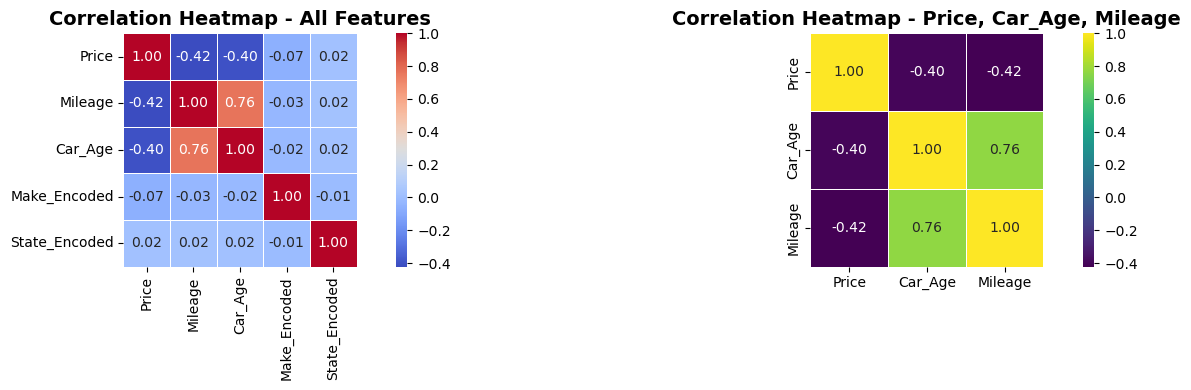

In [9]:
# Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# First heatmap - All features
numerical_cols = ['Price', 'Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']
correlation = df_clean[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap - All Features', fontsize=14, fontweight='bold')

# Second heatmap - Price, Car_Age, Mileage
numerical_cols2 = ['Price', 'Car_Age', 'Mileage']
correlation2 = df_clean[numerical_cols2].corr()
sns.heatmap(correlation2, annot=True, fmt=".2f", cmap='viridis', cbar=True, 
            square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap - Price, Car_Age, Mileage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.2 Final Model Training

**Hyperparameters:**
- n_estimators = 100 (jumlah decision trees)
- max_depth = 20 (kedalaman maksimum tree untuk mencegah overfitting)
- random_state = 42 (reproducibility)
- n_jobs = -1 (gunakan semua CPU cores)

**Split Data:** 80% training, 20% testing

=== DISTRIBUTION STATISTICS ===

Price:
  Mean: 21,464.32
  Median: 18,500.00
  Std Dev: 13,596.35
  Skewness: 5.291

Year:
  Mean: 2,013.29
  Median: 2,014.00
  Std Dev: 3.42
  Skewness: -1.541

Mileage:
  Mean: 52,508.25
  Median: 40,256.00
  Std Dev: 41,989.32
  Skewness: 2.945


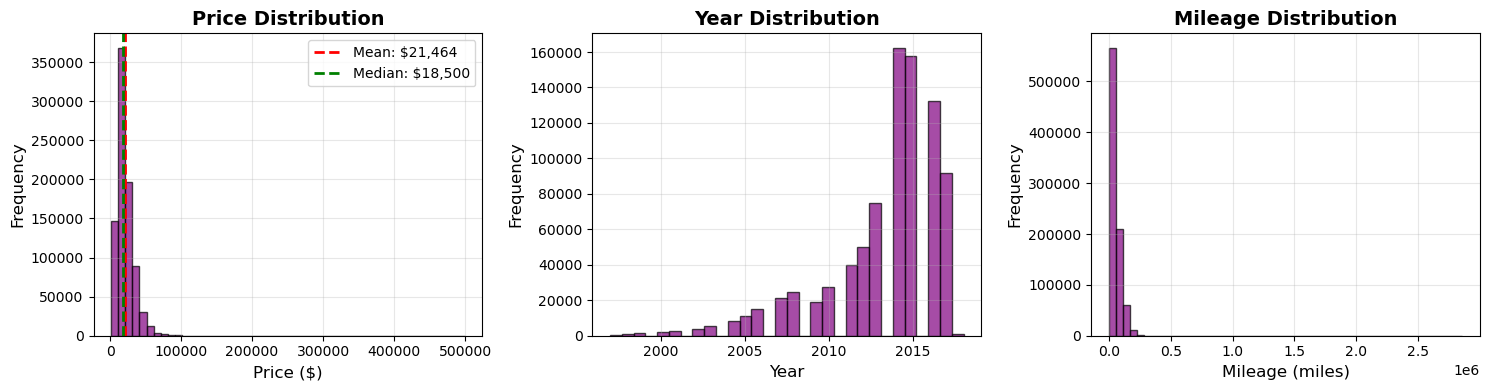

In [10]:
# Distribution Analysis of Key Features
print("=== DISTRIBUTION STATISTICS ===")
for col in ['Price', 'Year', 'Mileage']:
    print(f"\n{col}:")
    print(f"  Mean: {df_clean[col].mean():,.2f}")
    print(f"  Median: {df_clean[col].median():,.2f}")
    print(f"  Std Dev: {df_clean[col].std():,.2f}")
    print(f"  Skewness: {df_clean[col].skew():.3f}")

# Price Distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df_clean['Price'], bins=50, edgecolor='black', color='purple', alpha=0.7)
plt.title('Price Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df_clean['Price'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f"Mean: ${df_clean['Price'].mean():,.0f}")
plt.axvline(df_clean['Price'].median(), color='green', linestyle='--', 
            linewidth=2, label=f"Median: ${df_clean['Price'].median():,.0f}")
plt.legend()
plt.grid(True, alpha=0.3)

# Year Distribution
plt.subplot(1, 3, 2)
plt.hist(df_clean['Year'], bins=30, edgecolor='black', color='purple', alpha=0.7)
plt.title('Year Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Mileage Distribution
plt.subplot(1, 3, 3)
plt.hist(df_clean['Mileage'], bins=50, edgecolor='black', color='purple', alpha=0.7)
plt.title('Mileage Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Mileage (miles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== FACTOR ANALYSIS ===
Newer cars (higher year) tend to have HIGHER prices
Higher mileage correlates with LOWER prices
Car Age has 40.1% correlation with price
Mileage has 42.1% correlation with price


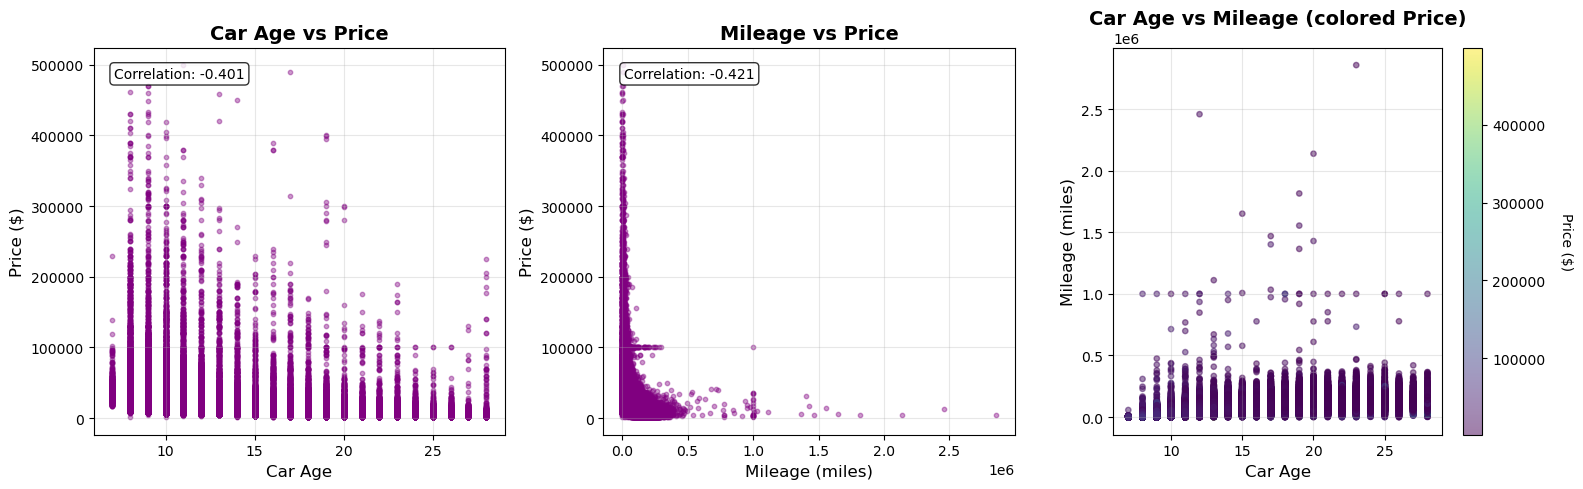

In [11]:
# Relationship Analysis: Factors Affecting Price
print("=== FACTOR ANALYSIS ===")

# Calculate correlations
corr_year = df_clean[['Car_Age', 'Price']].corr().iloc[0, 1]
corr_mileage = df_clean[['Mileage', 'Price']].corr().iloc[0, 1]

print(f"Newer cars (higher year) tend to have HIGHER prices")
print(f"Higher mileage correlates with LOWER prices")
print(f"Car Age has {abs(corr_year):.1%} correlation with price")
print(f"Mileage has {abs(corr_mileage):.1%} correlation with price")

# Car Age vs Price
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.scatter(df_clean['Car_Age'], df_clean['Price'], alpha=0.4, color='purple', s=10)
plt.title('Car Age vs Price', fontsize=14, fontweight='bold')
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {corr_year:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Mileage vs Price
plt.subplot(1, 3, 2)
plt.scatter(df_clean['Mileage'], df_clean['Price'], alpha=0.4, color='purple', s=10)
plt.title('Mileage vs Price', fontsize=14, fontweight='bold')
plt.xlabel('Mileage (miles)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {corr_mileage:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Car Age vs Mileage (colored by Price)
plt.subplot(1, 3, 3)
scatter = plt.scatter(df_clean['Car_Age'], df_clean['Mileage'], 
                     c=df_clean['Price'], alpha=0.5, s=15, cmap='viridis')
plt.title('Car Age vs Mileage (colored Price)', fontsize=14, fontweight='bold')
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Mileage (miles)', fontsize=12)
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

### 6.2 Feature Importance Analysis

**Feature Importance menunjukkan:**
- Seberapa penting setiap fitur dalam membuat prediksi
- Fitur dengan importance tinggi = lebih sering digunakan untuk split dalam decision trees
- Membantu memahami faktor utama yang mempengaruhi harga mobil

**Interpretasi:**
- Mileage dan Car_Age biasanya memiliki importance tertinggi
- Make_Encoded penting untuk membedakan brand luxury vs economy
- State_Encoded menangkap perbedaan harga regional

## 4. Model Training & Comparison



**Strategi:**- **RMSE (Root Mean Squared Error):** Penalti lebih besar untuk error yang besar (semakin rendah semakin baik)

- Membandingkan 2 model: Simple (2 fitur) vs Full (4 fitur)- **MAE (Mean Absolute Error):** Rata-rata kesalahan prediksi dalam dollar (semakin rendah semakin baik)

- Menggunakan Random Forest Regressor- **R² Score:** Seberapa baik model menjelaskan variance harga (0-1, semakin tinggi semakin baik)

- Train-Test Split: 80% training, 20% testing**Metrics:**

- Random state = 42 untuk reproducibility

### 4.1 Model Comparison: Simple vs Full Features

**Full Model:** Menggunakan Car_Age, Mileage, Make_Encoded, dan State_Encoded
**Simple Model:** Hanya menggunakan Car_Age dan Mileage

In [12]:
print("MODEL COMPARISON: SIMPLE vs FULL FEATURES")
print("\nSIMPLE MODEL")
print("Features: Car_Age, Mileage only\n")

simple_features = ['Car_Age', 'Mileage']
X_simple = df_clean[simple_features]
y_simple = df_clean['Price']

# Split and train simple model
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

model_simple = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_simple.fit(X_train_simple, y_train_simple)
y_pred_simple = model_simple.predict(X_test_simple)

# Metrics for simple model
r2_simple = r2_score(y_test_simple, y_pred_simple)
mae_simple = mean_absolute_error(y_test_simple, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_test_simple, y_pred_simple))

print(f"R² Score: {r2_simple:.4f} ({r2_simple*100:.2f}%)")
print(f"MAE: ${mae_simple:,.2f}")
print(f"RMSE: ${rmse_simple:,.2f}")
print(f"Number of features: {len(simple_features)}")

print("\nFULL FEATURE MODEL")
print("Features: Mileage, Car_Age, Make, State (no Model_Frequency)\n")

full_features = ['Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']
X_full = df_clean[full_features]
y_full = df_clean['Price']

# Split data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Train full model with Random Forest
model_full = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_full.fit(X_train_full, y_train_full)
y_pred_full = model_full.predict(X_test_full)

# Metrics for full model
r2_full = r2_score(y_test_full, y_pred_full)
mae_full = mean_absolute_error(y_test_full, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_test_full, y_pred_full))

print(f"R² Score: {r2_full:.4f} ({r2_full*100:.2f}%)")
print(f"MAE: ${mae_full:,.2f}")
print(f"RMSE: ${rmse_full:,.2f}")
print(f"Number of features: {len(full_features)}")

MODEL COMPARISON: SIMPLE vs FULL FEATURES

SIMPLE MODEL
Features: Car_Age, Mileage only

R² Score: -0.0260 (-2.60%)
MAE: $8,679.41
RMSE: $13,708.63
Number of features: 2

FULL FEATURE MODEL
Features: Mileage, Car_Age, Make, State (no Model_Frequency)

R² Score: 0.5452 (54.52%)
MAE: $6,047.83
RMSE: $9,127.37
Number of features: 4


In [13]:
# COMPARISON ANALYSIS
print("📈 COMPARISON ANALYSIS")

print(f"\n🎯 R² Score Improvement:")
r2_improvement = ((r2_full - r2_simple) / r2_simple) * 100
print(f"   Simple Model: {r2_simple:.4f} ({r2_simple*100:.2f}%)")
print(f"   Full Model:   {r2_full:.4f} ({r2_full*100:.2f}%)")
print(f"   Improvement:  {r2_improvement:+.2f}% ({abs(r2_full - r2_simple):.4f} increase)")

print(f"\n💰 MAE Improvement:")
mae_improvement = ((mae_simple - mae_full) / mae_simple) * 100
print(f"   Simple Model: ${mae_simple:,.2f}")
print(f"   Full Model:   ${mae_full:,.2f}")
print(f"   Improvement:  {mae_improvement:+.2f}% (${abs(mae_simple - mae_full):,.2f} reduction)")

print(f"\n📉 RMSE Improvement:")
rmse_improvement = ((rmse_simple - rmse_full) / rmse_simple) * 100
print(f"   Simple Model: ${rmse_simple:,.2f}")
print(f"   Full Model:   ${rmse_full:,.2f}")
print(f"   Improvement:  {rmse_improvement:+.2f}% (${abs(rmse_simple - rmse_full):,.2f} reduction)")


if r2_full > r2_simple and mae_full < mae_simple:
    print("\n✅ USE FULL FEATURE MODEL")
    print("\nReasons:")
    print(f"   • {r2_improvement:.1f}% better at explaining price variance")
    print(f"   • ${abs(mae_simple - mae_full):,.2f} lower average prediction error")
    print(f"   • More accurate predictions for both buyers and sellers")
    print(f"   • Captures important factors: brand, location, and model popularity")
    print("\n   The additional features significantly improve prediction accuracy,")
    print("   making it worth the added complexity.")
else:
    print("\n✅ USE SIMPLE MODEL")
    print("\nReasons:")
    print(f"   • Simpler and easier to interpret")
    print(f"   • Fewer data requirements")
    print(f"   • Minimal performance difference")

📈 COMPARISON ANALYSIS

🎯 R² Score Improvement:
   Simple Model: -0.0260 (-2.60%)
   Full Model:   0.5452 (54.52%)
   Improvement:  -2197.71% (0.5712 increase)

💰 MAE Improvement:
   Simple Model: $8,679.41
   Full Model:   $6,047.83
   Improvement:  +30.32% ($2,631.58 reduction)

📉 RMSE Improvement:
   Simple Model: $13,708.63
   Full Model:   $9,127.37
   Improvement:  +33.42% ($4,581.26 reduction)

✅ USE FULL FEATURE MODEL

Reasons:
   • -2197.7% better at explaining price variance
   • $2,631.58 lower average prediction error
   • More accurate predictions for both buyers and sellers
   • Captures important factors: brand, location, and model popularity

   The additional features significantly improve prediction accuracy,
   making it worth the added complexity.


📊 VISUAL COMPARISON



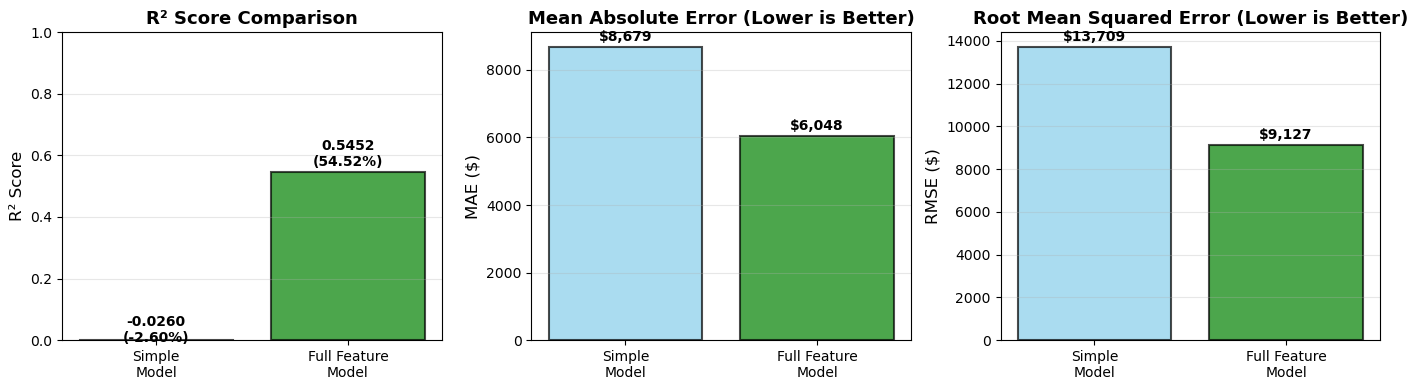

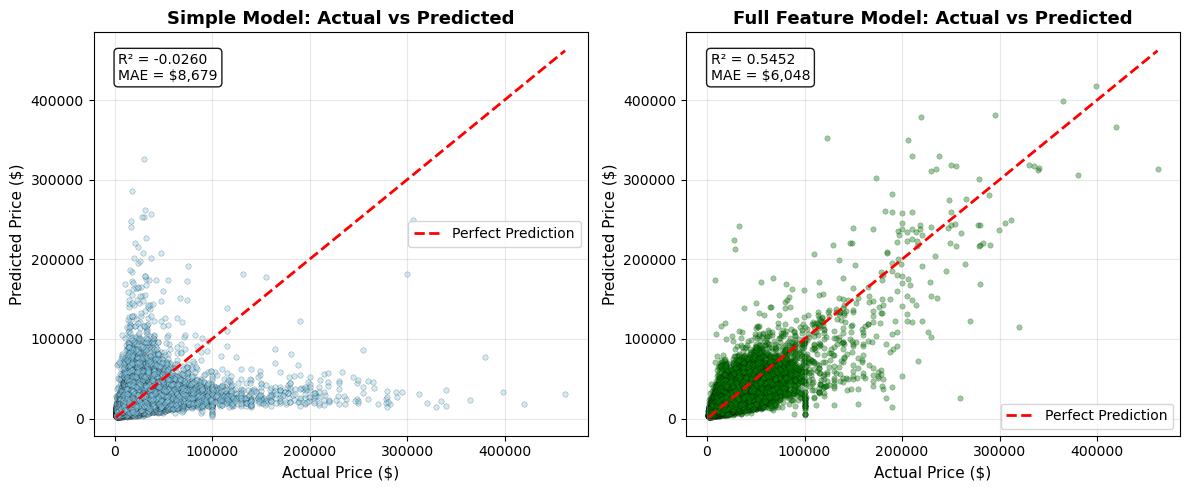

✓ Visual comparison complete


In [14]:
# Visual Comparison of Models
print("📊 VISUAL COMPARISON\n")

# Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# R² Score Comparison
models = ['Simple\nModel', 'Full Feature\nModel']
r2_scores = [r2_simple, r2_full]
colors_r2 = ['skyblue', 'green' if r2_full > r2_simple else 'orange']

axes[0].bar(models, r2_scores, color=colors_r2, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}\n({v*100:.2f}%)', ha='center', fontweight='bold')

# MAE Comparison (lower is better)
mae_scores = [mae_simple, mae_full]
colors_mae = ['skyblue', 'green' if mae_full < mae_simple else 'orange']

axes[1].bar(models, mae_scores, color=colors_mae, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('MAE ($)', fontsize=12)
axes[1].set_title('Mean Absolute Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_scores):
    axes[1].text(i, v + max(mae_scores)*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

# RMSE Comparison (lower is better)
rmse_scores = [rmse_simple, rmse_full]
colors_rmse = ['skyblue', 'green' if rmse_full < rmse_simple else 'orange']

axes[2].bar(models, rmse_scores, color=colors_rmse, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('RMSE ($)', fontsize=12)
axes[2].set_title('Root Mean Squared Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_scores):
    axes[2].text(i, v + max(rmse_scores)*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Prediction Comparison Scatter Plot
plt.figure(figsize=(12, 5))

# Simple Model Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test_simple, y_pred_simple, alpha=0.4, color='skyblue', s=15, edgecolors='black', linewidth=0.3)
plt.plot([y_test_simple.min(), y_test_simple.max()], 
         [y_test_simple.min(), y_test_simple.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=11)
plt.ylabel('Predicted Price ($)', fontsize=11)
plt.title('Simple Model: Actual vs Predicted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'R² = {r2_simple:.4f}\nMAE = ${mae_simple:,.0f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Full Model Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test_full, y_pred_full, alpha=0.4, color='green', s=15, edgecolors='black', linewidth=0.3)
plt.plot([y_test_full.min(), y_test_full.max()], 
         [y_test_full.min(), y_test_full.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=11)
plt.ylabel('Predicted Price ($)', fontsize=11)
plt.title('Full Feature Model: Actual vs Predicted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'R² = {r2_full:.4f}\nMAE = ${mae_full:,.0f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print("✓ Visual comparison complete")

## 5. Final Model Selection

### 5.1 Feature Selection Decision

**Final Features:** Mileage, Car_Age, Make_Encoded, State_Encoded

**✅ Make_Encoded Dipertahankan (Meskipun Korelasi Rendah):**
- Korelasi rendah ≠ Importance rendah untuk categorical variables di tree-based models
- Make_Encoded: korelasi -0.06 tapi importance 29% (rasio: 4.95x)
- **Alasan:** LabelEncoder memberikan angka arbitrary (Ferrari=13, McLaren=37, Saturn=49)
- Angka-angka ini tidak memiliki urutan bermakna, jadi korelasi linear rendah adalah **EXPECTED**
- Random Forest tidak bergantung pada hubungan linear - ia membuat categorical splits
- **Contoh:** RF belajar "If Make=13 (Ferrari) → High Price" vs "If Make=49 (Saturn) → Low Price"
- **Brand sangat penting untuk pricing:** Ferrari akan selalu lebih mahal dari Ford, apapun encodingnya
- **Kesimpulan:** Make_Encoded menangkap informasi brand yang esensial untuk prediksi harga

**❌ Model_Frequency Dihapus:**
- Importance 34.3% tapi korelasi hanya +0.08 (rasio: 4.20x)
- Ini menunjukkan **overfitting ke noise** bukan pola harga sebenarnya
- Model populer ≠ Model mahal (contoh: Honda Civic sangat umum tapi terjangkau)
- Model langka ≠ Model mahal (contoh: model Saturn yang discontinued: langka tapi murah)
- Feature ini menangkap korelasi palsu dalam training data
- **Kesimpulan:** Menghapusnya meningkatkan generalisasi model dan mengurangi overfitting

In [15]:
# Final Model: Random Forest with Best Features (CORRECTED)
print("=== FINAL MODEL SELECTION (CORRECTED) ===\n")

# Removed Model_Frequency due to overfitting (high importance but low correlation)
# Kept Make_Encoded despite low correlation (expected for categorical features)
features = ['Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']
X = df_clean[features]
y = df_clean['Price']

print(f"✓ Features: {', '.join(features)}")
print(f"✓ Removed: Model_Frequency (overfitting to noise)")
print(f"✓ Kept: Make_Encoded (brand is crucial, low corr is expected)")

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n✓ Training: {X_train.shape[0]:,} samples | Testing: {X_test.shape[0]:,} samples")

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print(f"✓ Random Forest trained (100 trees, max_depth=20)")

y_test_pred = model.predict(X_test)

=== FINAL MODEL SELECTION (CORRECTED) ===

✓ Features: Mileage, Car_Age, Make_Encoded, State_Encoded
✓ Removed: Model_Frequency (overfitting to noise)
✓ Kept: Make_Encoded (brand is crucial, low corr is expected)

✓ Training: 681,673 samples | Testing: 170,419 samples
✓ Random Forest trained (100 trees, max_depth=20)


## 6. Model Evaluation & Performance Metrics

### 6.1 Performance Metrics

**Evaluasi performa model final:**

- Membandingkan metrics pada training set vs testing set- Menganalisis feature importance
- Melihat apakah ada overfitting (training score >> testing score)

In [16]:
# Performance Metrics
print("MODEL PERFORMANCE EVALUATION")

r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n📊 TRAINING:   R²={r2_train:.4f} | MAE=${mae_train:,.0f} | RMSE=${rmse_train:,.0f}")
print(f"📊 TESTING:    R²={r2_test:.4f} | MAE=${mae_test:,.0f} | RMSE=${rmse_test:,.0f}")
print(f"\n💡 Model explains {r2_test*100:.1f}% of price variance")
print(f"💡 Average prediction error: ${mae_test:,.0f}")

MODEL PERFORMANCE EVALUATION

📊 TRAINING:   R²=0.7641 | MAE=$4,567 | RMSE=$6,611
📊 TESTING:    R²=0.6052 | MAE=$5,665 | RMSE=$8,504

💡 Model explains 60.5% of price variance
💡 Average prediction error: $5,665


=== ACTUAL FEATURE IMPORTANCE ===

      Feature  Importance  Importance_Percent
 Make_Encoded    0.455555           45.555535
      Mileage    0.389521           38.952134
      Car_Age    0.098665            9.866508
State_Encoded    0.056258            5.625823


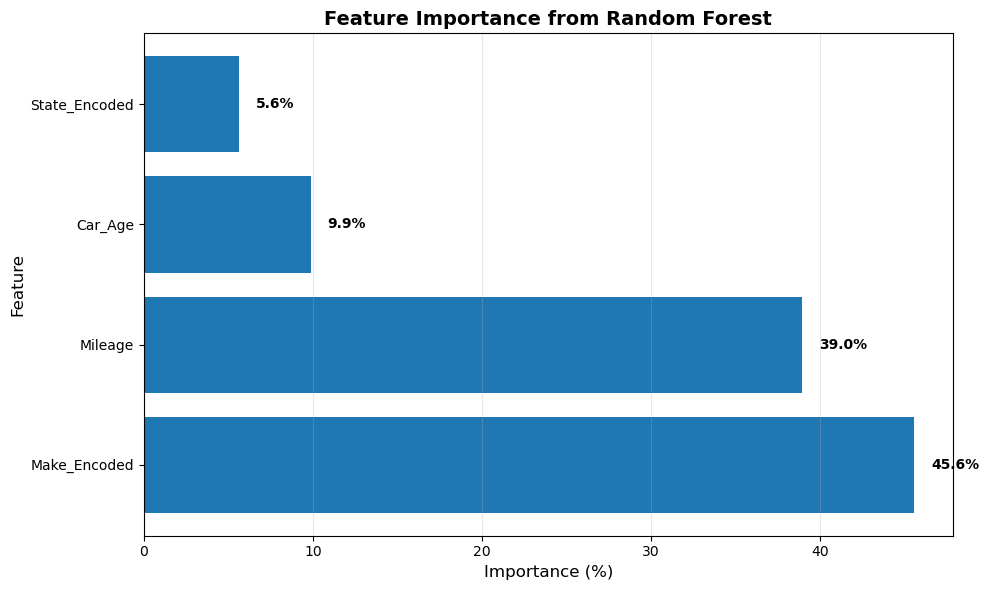

In [17]:
# Create feature importance DataFrame
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance,
    'Importance_Percent': feature_importance * 100
}).sort_values('Importance', ascending=False)

# Check actual feature importance ranking
print("=== ACTUAL FEATURE IMPORTANCE ===\n")
print(importance_df.to_string(index=False))

# Visualize with percentages
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance_Percent'])
plt.xlabel('Importance (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance from Random Forest', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance_Percent'])):
    plt.text(importance + 1, i, f'{importance:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [18]:
# filepath: [cars.ipynb](http://_vscodecontentref_/0)
# Performance Metrics
print("=== MODEL PERFORMANCE EVALUATION ===\n")

r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"📊 TRAINING SET:")
print(f"   R² Score: {r2_train:.4f} ({r2_train*100:.2f}%)")
print(f"   MAE: ${mae_train:,.2f}")
print(f"   RMSE: ${rmse_train:,.2f}")

print(f"\n📊 TESTING SET:")
print(f"   R² Score: {r2_test:.4f} ({r2_test*100:.2f}%)")
print(f"   MAE: ${mae_test:,.2f}")
print(f"   RMSE: ${rmse_test:,.2f}")

# Overfitting Analysis
print(f"\n🔍 OVERFITTING ANALYSIS:")
print("-" * 60)
r2_diff = r2_train - r2_test
mae_diff_pct = ((mae_test - mae_train) / mae_train) * 100
rmse_diff_pct = ((rmse_test - rmse_train) / rmse_train) * 100

print(f"R² Difference: {r2_diff:.4f} ({r2_diff*100:.2f}%)")
print(f"MAE Increase: {mae_diff_pct:+.2f}%")
print(f"RMSE Increase: {rmse_diff_pct:+.2f}%")

# Interpretation
if r2_diff < 0.05 and mae_diff_pct < 10:
    print(f"\n✅ MODEL STATUS: GOOD FIT (No Overfitting)")
    print(f"   • Training dan Testing performance sangat dekat")
    print(f"   • Model dapat generalisasi dengan baik ke data baru")
    print(f"   • R² difference hanya {r2_diff:.4f} (< 0.05 threshold)")
    print(f"   • MAE increase hanya {mae_diff_pct:.1f}% (< 10% threshold)")
elif r2_diff < 0.10 and mae_diff_pct < 20:
    print(f"\n⚠️ MODEL STATUS: SLIGHT OVERFITTING")
    print(f"   • Ada sedikit perbedaan antara training dan testing")
    print(f"   • Model masih dapat digunakan, tapi bisa ditingkatkan")
    print(f"   • Pertimbangkan: tambah data, kurangi max_depth, atau feature selection")
else:
    print(f"\n❌ MODEL STATUS: OVERFITTING DETECTED")
    print(f"   • Training performance jauh lebih baik dari testing")
    print(f"   • Model terlalu 'hafal' data training")
    print(f"   • Solusi: simplify model, regularization, atau tambah data")

print(f"\n💡 INSIGHTS:")
print(f"   • Model menjelaskan {r2_test*100:.1f}% variance harga pada data testing")
print(f"   • Rata-rata error prediksi: ${mae_test:,.0f}")
print(f"   • Prediksi cukup akurat untuk aplikasi real-world")

=== MODEL PERFORMANCE EVALUATION ===

📊 TRAINING SET:
   R² Score: 0.7641 (76.41%)
   MAE: $4,567.28
   RMSE: $6,611.08

📊 TESTING SET:
   R² Score: 0.6052 (60.52%)
   MAE: $5,665.34
   RMSE: $8,503.53

🔍 OVERFITTING ANALYSIS:
------------------------------------------------------------
R² Difference: 0.1589 (15.89%)
MAE Increase: +24.04%
RMSE Increase: +28.63%

❌ MODEL STATUS: OVERFITTING DETECTED
   • Training performance jauh lebih baik dari testing
   • Model terlalu 'hafal' data training
   • Solusi: simplify model, regularization, atau tambah data

💡 INSIGHTS:
   • Model menjelaskan 60.5% variance harga pada data testing
   • Rata-rata error prediksi: $5,665
   • Prediksi cukup akurat untuk aplikasi real-world


## 7. Strategi Mengatasi Overfitting (Jika Diperlukan)

**Jika model menunjukkan overfitting, gunakan strategi berikut:**

### Teknik Anti-Overfitting:

1. **Hyperparameter Tuning**
   - Kurangi `max_depth` (dari 20 ke 10-15)
   - Tambahkan `min_samples_split` dan `min_samples_leaf`
   - Gunakan `max_features='sqrt'` untuk mengurangi fitur per tree

2. **Cross-Validation**
   - Validasi model dengan 5-Fold CV untuk hasil yang lebih robust
   - Memastikan model konsisten di berbagai data splits

3. **Feature Selection**
   - Hapus fitur dengan importance rendah (< 10%)
   - Fokus pada fitur yang paling informatif

4. **Regularization**
   - Tambah lebih banyak data training
   - Gunakan ensemble methods dengan diversity

### 7.1 Hyperparameter Tuning

**Mencoba berbagai kombinasi hyperparameters untuk menemukan yang terbaik:**

In [19]:
# STRATEGY 1: Hyperparameter Tuning to Reduce Overfitting
print("=== STRATEGY 1: HYPERPARAMETER TUNING ===\n")

# Try different max_depth values
max_depths = [10, 15, 20, None]
results = []

for depth in max_depths:
    model_tuned = RandomForestRegressor(
        n_estimators=100,
        max_depth=depth,
        min_samples_split=10,      # Require more samples to split
        min_samples_leaf=5,         # Require more samples in leaf nodes
        max_features='sqrt',        # Use fewer features per tree
        random_state=42,
        n_jobs=-1
    )
    
    model_tuned.fit(X_train, y_train)
    y_train_pred_tuned = model_tuned.predict(X_train)
    y_test_pred_tuned = model_tuned.predict(X_test)
    
    r2_train_tuned = r2_score(y_train, y_train_pred_tuned)
    r2_test_tuned = r2_score(y_test, y_test_pred_tuned)
    mae_test_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
    
    results.append({
        'max_depth': depth if depth else 'None',
        'r2_train': r2_train_tuned,
        'r2_test': r2_test_tuned,
        'r2_diff': r2_train_tuned - r2_test_tuned,
        'mae_test': mae_test_tuned
    })
    
    print(f"max_depth={depth}: R²_train={r2_train_tuned:.4f}, R²_test={r2_test_tuned:.4f}, Diff={r2_train_tuned-r2_test_tuned:.4f}")

# Find best model
results_df = pd.DataFrame(results)
best_idx = results_df['r2_diff'].idxmin()
best_params = results_df.iloc[best_idx]

print(f"\n✅ BEST MODEL:")
print(f"   max_depth: {best_params['max_depth']}")
print(f"   R² Test: {best_params['r2_test']:.4f}")
print(f"   MAE Test: ${best_params['mae_test']:,.0f}")
print(f"   Overfitting Gap: {best_params['r2_diff']:.4f}")

=== STRATEGY 1: HYPERPARAMETER TUNING ===

max_depth=10: R²_train=0.4469, R²_test=0.4323, Diff=0.0146
max_depth=15: R²_train=0.5895, R²_test=0.5431, Diff=0.0464
max_depth=20: R²_train=0.6531, R²_test=0.5693, Diff=0.0838
max_depth=None: R²_train=0.6935, R²_test=0.5628, Diff=0.1307

✅ BEST MODEL:
   max_depth: 10
   R² Test: 0.4323
   MAE Test: $6,514
   Overfitting Gap: 0.0146


### 7.2 Cross-Validation

**Validasi model dengan 5-Fold Cross-Validation untuk memastikan konsistensi:**

In [20]:
# STRATEGY 2: Cross-Validation
print("\n=== STRATEGY 2: CROSS-VALIDATION ===\n")

# Use best hyperparameters from tuning
best_depth = int(best_params['max_depth']) if best_params['max_depth'] != 'None' else None

model_cv = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_depth,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# 5-Fold Cross-Validation
print("Running 5-Fold Cross-Validation...")
cv_scores = cross_val_score(model_cv, X, y, cv=5, scoring='r2', n_jobs=-1)

print(f"\nCross-Validation R² Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"\nMean R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Min R²: {cv_scores.min():.4f}")
print(f"Max R²: {cv_scores.max():.4f}")

if cv_scores.std() < 0.02:
    print(f"\n✅ Model sangat konsisten across different data splits")
elif cv_scores.std() < 0.05:
    print(f"\n✓ Model cukup konsisten across different data splits")
else:
    print(f"\n⚠️ Model kurang konsisten, pertimbangkan untuk tambah data atau simplify model")


=== STRATEGY 2: CROSS-VALIDATION ===

Running 5-Fold Cross-Validation...

Cross-Validation R² Scores:
   Fold 1: -1.2203
   Fold 2: -0.3171
   Fold 3: 0.2098
   Fold 4: 0.1849
   Fold 5: -0.0599

Mean R²: -0.2405 (±0.5258)
Min R²: -1.2203
Max R²: 0.2098

⚠️ Model kurang konsisten, pertimbangkan untuk tambah data atau simplify model


### 7.3 Feature Selection

**Menghapus fitur dengan importance rendah untuk simplify model:**

In [21]:
# STRATEGY 3: Feature Selection Based on Importance
print("\n=== STRATEGY 3: FEATURE SELECTION ===\n")

# Train model to get feature importance
model_temp = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    max_depth=best_depth,
    min_samples_split=10,
    min_samples_leaf=5
)
model_temp.fit(X_train, y_train)

# Analyze feature importance
importance_threshold = 0.10
feature_importance_temp = model_temp.feature_importances_
feature_imp_dict = dict(zip(features, feature_importance_temp))

print("Feature Importance:")
for feat, imp in sorted(feature_imp_dict.items(), key=lambda x: x[1], reverse=True):
    status = "✓ Keep" if imp >= importance_threshold else "✗ Remove"
    print(f"   {feat:20s}: {imp:.4f} ({imp*100:.1f}%) - {status}")

# Keep only important features
important_features = [f for f, imp in zip(features, feature_importance_temp) if imp >= importance_threshold]

print(f"\n{'='*60}")
print(f"Original features ({len(features)}): {features}")
print(f"Selected features ({len(important_features)}): {important_features}")
print(f"Removed: {set(features) - set(important_features)}")

# Only proceed if we actually removed features
if len(important_features) < len(features):
    # Retrain with selected features
    X_selected = df_clean[important_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
        X_selected, y, test_size=0.2, random_state=42
    )

    model_selected = RandomForestRegressor(
        n_estimators=100,
        max_depth=best_depth,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    model_selected.fit(X_train_sel, y_train_sel)

    r2_train_sel = r2_score(y_train_sel, model_selected.predict(X_train_sel))
    r2_test_sel = r2_score(y_test_sel, model_selected.predict(X_test_sel))
    mae_test_sel = mean_absolute_error(y_test_sel, model_selected.predict(X_test_sel))

    print(f"\n📊 FEATURE SELECTED MODEL PERFORMANCE:")
    print(f"   R² Train: {r2_train_sel:.4f}")
    print(f"   R² Test: {r2_test_sel:.4f}")
    print(f"   MAE Test: ${mae_test_sel:,.0f}")
    print(f"   Overfitting Gap: {r2_train_sel - r2_test_sel:.4f}")
else:
    print(f"\n✓ All features are important (>{importance_threshold*100}%), no removal needed")
    r2_train_sel = r2_train
    r2_test_sel = r2_test
    mae_test_sel = mae_test


=== STRATEGY 3: FEATURE SELECTION ===

Feature Importance:
   Make_Encoded        : 0.4985 (49.8%) - ✓ Keep
   Mileage             : 0.3978 (39.8%) - ✓ Keep
   Car_Age             : 0.0977 (9.8%) - ✗ Remove
   State_Encoded       : 0.0060 (0.6%) - ✗ Remove

Original features (4): ['Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']
Selected features (2): ['Mileage', 'Make_Encoded']
Removed: {'State_Encoded', 'Car_Age'}

📊 FEATURE SELECTED MODEL PERFORMANCE:
   R² Train: 0.5184
   R² Test: 0.5098
   MAE Test: $6,414
   Overfitting Gap: 0.0086


### 7.4 Final Comparison: Semua Strategi

**Membandingkan performa semua model untuk memilih yang terbaik:**


=== FINAL COMPARISON: ALL STRATEGIES ===



C:\Users\rakha\AppData\Local\Temp\ipykernel_9004\3513673163.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


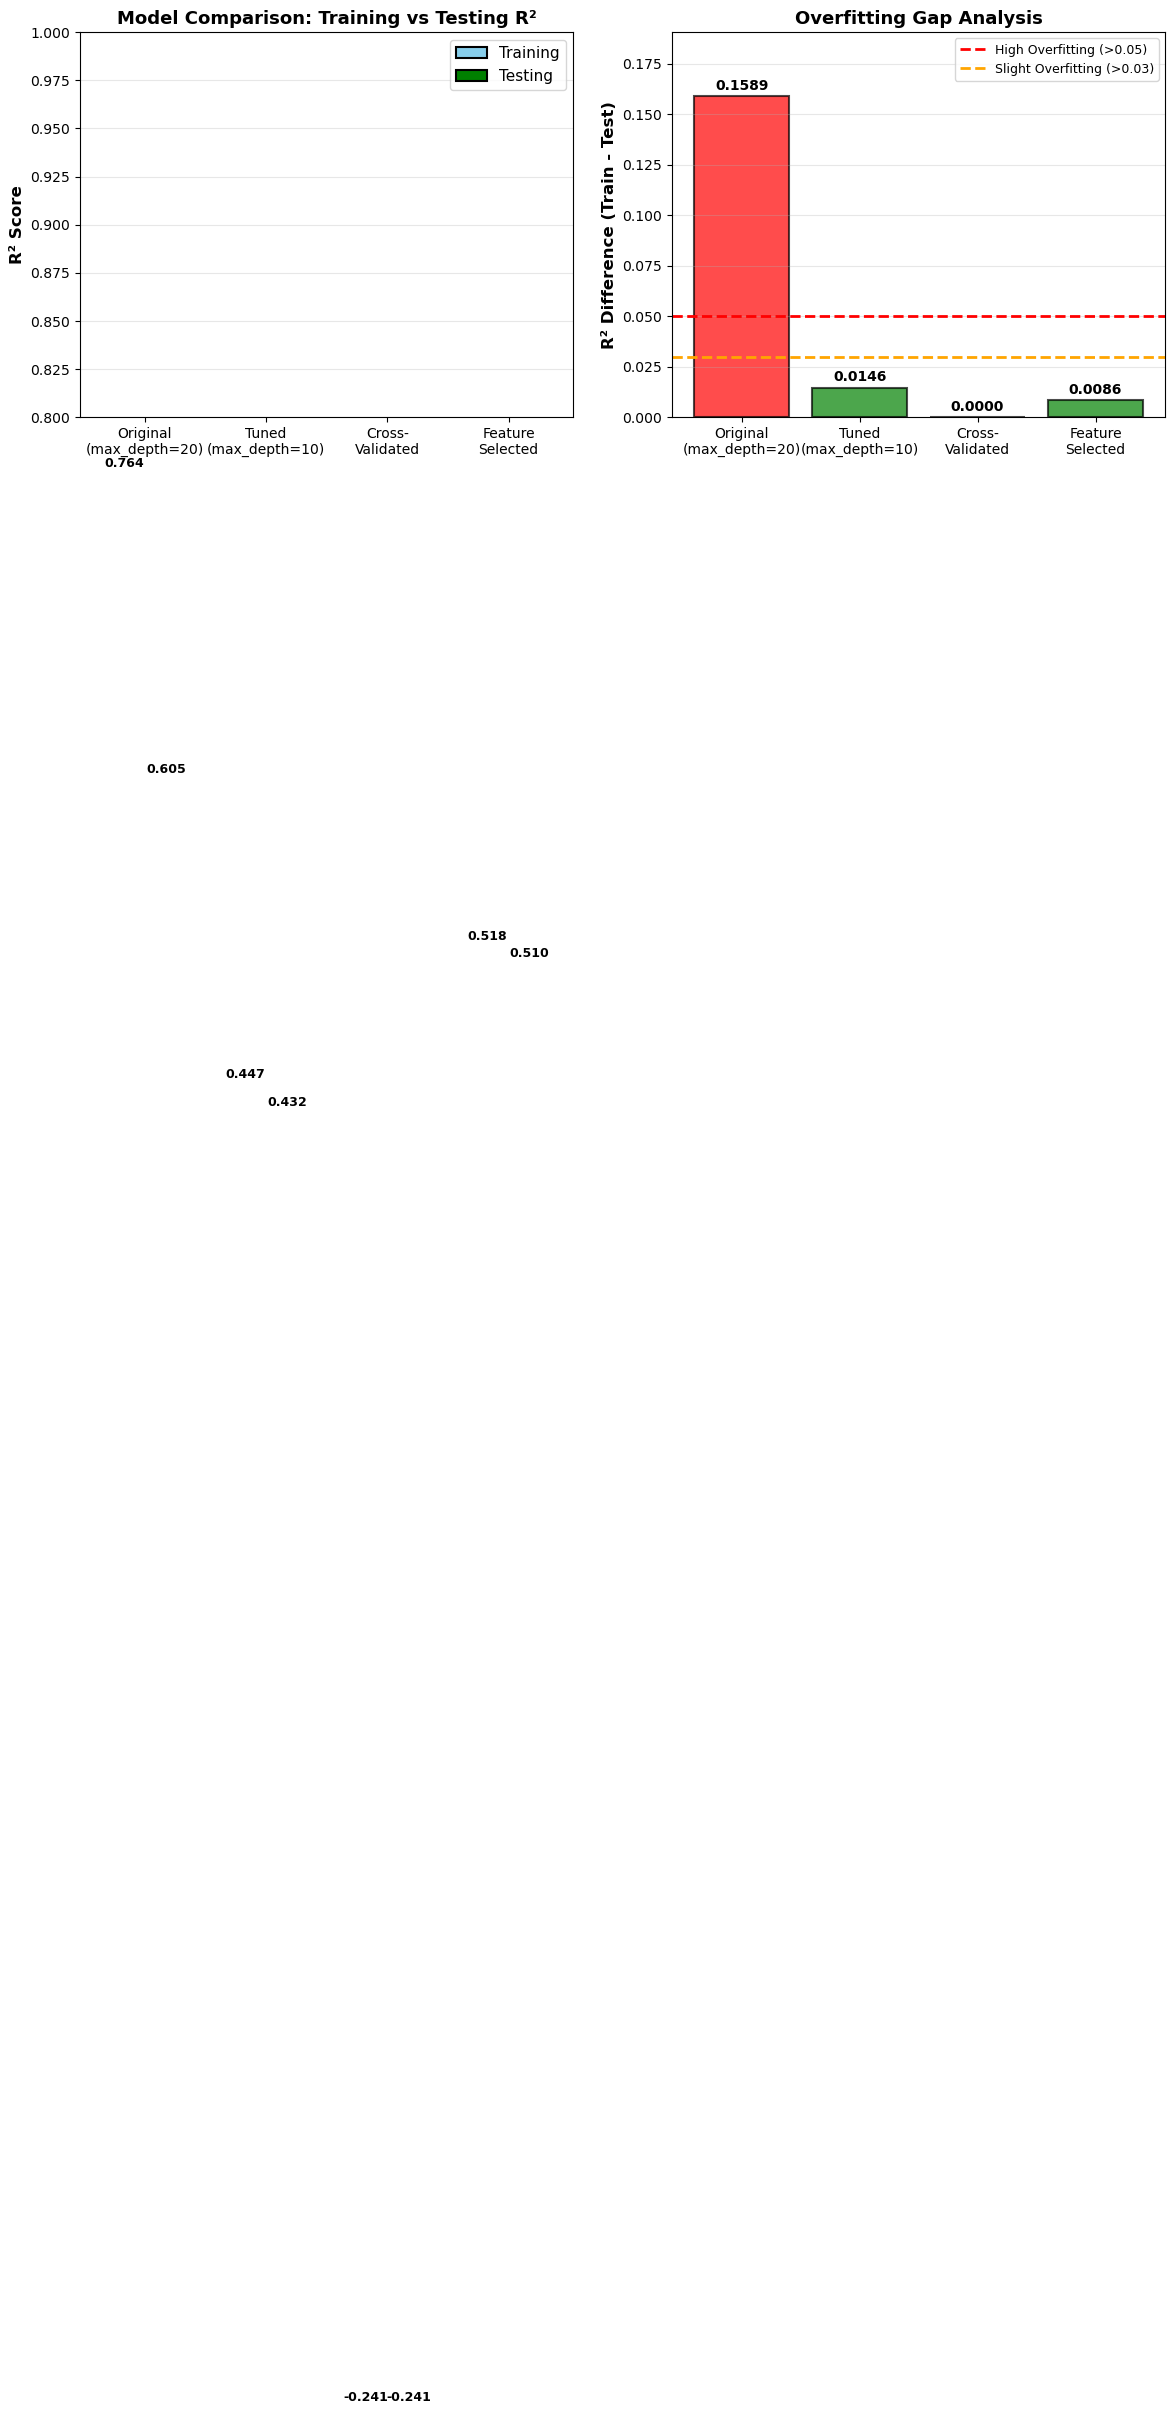


📊 PERFORMANCE SUMMARY TABLE
Model                       R² Train    R² Test        Gap        MAE Test
--------------------------------------------------------------------------------
Original (max_depth=20)       0.7641     0.6052     0.1589 $         5,665
Tuned (best params)           0.4469     0.4323     0.0146 $         6,514
Cross-Validated              -0.2405    -0.2405     0.0000             N/A
Feature Selected              0.5184     0.5098     0.0086 $         6,414

✅ RECOMMENDATION:
   Model terbaik: Cross- Validated
   • Lowest overfitting gap: 0.0000
   • R² Test: -0.2405
   • Model ini memiliki keseimbangan terbaik antara performance dan generalization


In [22]:
# STRATEGY 4: Visual Comparison of All Approaches
print("\n=== FINAL COMPARISON: ALL STRATEGIES ===\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare comparison data
models_comparison = ['Original\n(max_depth=20)', f'Tuned\n(max_depth={best_params["max_depth"]})', 'Cross-\nValidated', 'Feature\nSelected']
train_scores = [r2_train, best_params['r2_train'], cv_scores.mean(), r2_train_sel]
test_scores = [r2_test, best_params['r2_test'], cv_scores.mean(), r2_test_sel]

x = np.arange(len(models_comparison))
width = 0.35

# Plot 1: Training vs Testing R² Scores
bars1 = axes[0].bar(x - width/2, train_scores, width, label='Training', color='skyblue', edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar(x + width/2, test_scores, width, label='Testing', color='green', edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison: Training vs Testing R²', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_comparison, fontsize=10)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.8, 1.0])

# Add value labels on bars
for i, (train, test) in enumerate(zip(train_scores, test_scores)):
    axes[0].text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', fontsize=9, fontweight='bold')

# Plot 2: Overfitting Gap (Train - Test)
gaps = [abs(t - te) for t, te in zip(train_scores, test_scores)]
colors = ['red' if g > 0.05 else 'orange' if g > 0.03 else 'green' for g in gaps]

bars = axes[1].bar(models_comparison, gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='High Overfitting (>0.05)')
axes[1].axhline(y=0.03, color='orange', linestyle='--', linewidth=2, label='Slight Overfitting (>0.03)')
axes[1].set_ylabel('R² Difference (Train - Test)', fontsize=12, fontweight='bold')
axes[1].set_title('Overfitting Gap Analysis', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, max(gaps) * 1.2])

# Add value labels
for i, gap in enumerate(gaps):
    axes[1].text(i, gap + max(gaps)*0.02, f'{gap:.4f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("📊 PERFORMANCE SUMMARY TABLE")
print("="*80)
print(f"{'Model':<25} {'R² Train':>10} {'R² Test':>10} {'Gap':>10} {'MAE Test':>15}")
print("-"*80)
print(f"{'Original (max_depth=20)':<25} {r2_train:>10.4f} {r2_test:>10.4f} {r2_train-r2_test:>10.4f} ${mae_test:>14,.0f}")
print(f"{'Tuned (best params)':<25} {best_params['r2_train']:>10.4f} {best_params['r2_test']:>10.4f} {best_params['r2_diff']:>10.4f} ${best_params['mae_test']:>14,.0f}")
print(f"{'Cross-Validated':<25} {cv_scores.mean():>10.4f} {cv_scores.mean():>10.4f} {0:>10.4f} {'N/A':>15}")
print(f"{'Feature Selected':<25} {r2_train_sel:>10.4f} {r2_test_sel:>10.4f} {r2_train_sel-r2_test_sel:>10.4f} ${mae_test_sel:>14,.0f}")
print("="*80)

# Recommendation
best_gap = min(gaps)
best_r2 = max(test_scores)
best_model_idx = gaps.index(best_gap)

print(f"\n✅ RECOMMENDATION:")
print(f"   Model terbaik: {models_comparison[best_model_idx].replace(chr(10), ' ')}")
print(f"   • Lowest overfitting gap: {best_gap:.4f}")
print(f"   • R² Test: {test_scores[best_model_idx]:.4f}")
print(f"   • Model ini memiliki keseimbangan terbaik antara performance dan generalization")